In [ ]:
import pandas as pd

In [ ]:
# Load macro weekly summary
df = pd.read_csv("macro_weekly_summary.csv")

In [ ]:
# Step 1: Filter valid weeks
df = df[df['users_covered'] > 0]

In [ ]:
# Step 2: Aggregate total expected revenue (GMV) per week
gmv_df = df.groupby('week').agg({'expected_revenue': 'sum'}).reset_index()

In [ ]:
# Step 3: Rename for Prophet
df_gmv_prophet = gmv_df.rename(columns={'week': 'ds', 'expected_revenue': 'y'})
df_gmv_prophet['ds'] = pd.to_datetime(df_gmv_prophet['ds'].str.split('/').str[0])

In [ ]:
# Step 4: Prepare for LSTM
df_gmv_lstm = df_gmv_prophet.copy()

In [ ]:
# Optional: Preview
print("✅ Prophet-ready GMV data:")
print(df_gmv_prophet)

✅ Prophet-ready GMV data:
          ds              y
0 2020-12-28   35782.025271
1 2021-01-04   86003.772623
2 2021-01-11  101544.020158
3 2021-01-18   94126.959040
4 2021-01-25   92114.743833
5 2021-02-01   92213.537501
6 2021-02-08   84240.890944
7 2021-02-15   90741.801779
8 2021-02-22   87891.908177
9 2021-03-01    9540.276555


In [ ]:
print("\n✅ LSTM-ready GMV series:")
print(df_gmv_lstm['y'].values)


✅ LSTM-ready GMV series:
[ 35782.0252712   86003.77262279 101544.02015837  94126.95903999
  92114.74383341  92213.53750076  84240.89094372  90741.80177861
  87891.90817679   9540.27655491]


In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt

In [ ]:
# Step 1: Fit the model
model = Prophet()
model.fit(df_gmv_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdgnqfb7t/v4l00xbl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdgnqfb7t/c7u7a48p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45793', 'data', 'file=/tmp/tmpdgnqfb7t/v4l00xbl.json', 'init=/tmp/tmpdgnqfb7t/c7u7a48p.json', 'output', 'file=/tmp/tmpdgnqfb7t/prophet_model912r7bmn/prophet_model-20250620175826.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:58:26 - cmdstanpy - INFO - Chain [1] start processing
IN

In [ ]:
# Step 2: Future frame (4 weeks ahead)
future = model.make_future_dataframe(periods=4, freq='W-MON')

In [ ]:
# Step 3: Forecast
forecast = model.predict(future)

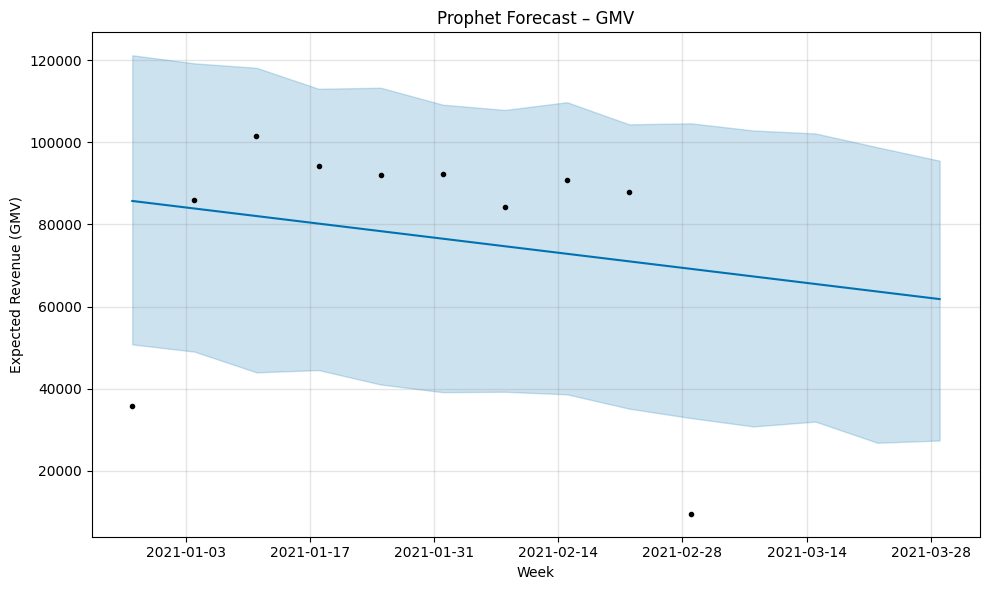

In [ ]:
# Step 4: Plot forecast
model.plot(forecast)
plt.title("Prophet Forecast – GMV")
plt.xlabel("Week")
plt.ylabel("Expected Revenue (GMV)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Step 5: View forecasted values
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(4)

,ds,yhat,yhat_lower,yhat_upper
10,2021-03-08,67323.617576,30803.217621,102861.086174
11,2021-03-15,65485.806188,31983.395977,102138.117974
12,2021-03-22,63647.994800,26828.754556,98777.163530
13,2021-03-29,61810.183413,27390.247436,95496.258874


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Step 1: Prepare series
gmv_series = df_gmv_lstm['y'].values.reshape(-1, 1)

In [ ]:
# Step 2: Normalize to 0–1
scaler = MinMaxScaler()
scaled_gmv = scaler.fit_transform(gmv_series)

In [ ]:
# Step 3: Create sequences (use last 4 weeks to predict next)
sequence_length = 4
X, y = [], []
for i in range(len(scaled_gmv) - sequence_length):
    X.append(scaled_gmv[i:i + sequence_length])
    y.append(scaled_gmv[i + sequence_length])
X = np.array(X)
y = np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [ ]:
# Step 4: Define & train LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=200, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Step 5: Forecast next 4 weeks
future_steps = 4
last_seq = scaled_gmv[-sequence_length:].reshape(1, sequence_length, 1)
predictions = []
for _ in range(future_steps):
    pred = model.predict(last_seq)[0][0]
    predictions.append(pred)
    last_seq = np.append(last_seq[:, 1:, :], [[[pred]]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


In [ ]:
# Step 6: Inverse transform
predicted_gmv = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

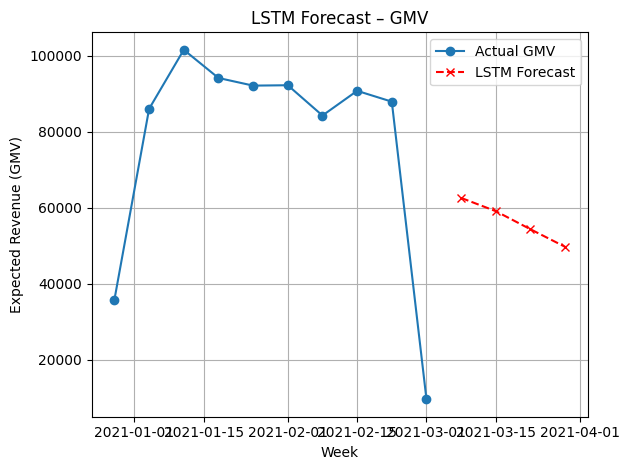

In [ ]:
# Step 7: Plot actual + forecasted
weeks_future = pd.date_range(start=df_gmv_lstm['ds'].iloc[-1] + pd.Timedelta(weeks=1), periods=future_steps, freq='W-MON')
plt.plot(df_gmv_lstm['ds'], df_gmv_lstm['y'], marker='o', label='Actual GMV')
plt.plot(weeks_future, predicted_gmv, marker='x', linestyle='--', color='red', label='LSTM Forecast')
plt.title("LSTM Forecast – GMV")
plt.xlabel("Week")
plt.ylabel("Expected Revenue (GMV)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Step 8: Print predicted values
print("🧠 LSTM Forecast – GMV (₹):")
for date, val in zip(weeks_future, predicted_gmv.flatten()):
    print(f"{date.date()} → ₹{val:,.2f}")

🧠 LSTM Forecast – GMV (₹):
2021-03-08 → ₹62,546.82
2021-03-15 → ₹59,057.72
2021-03-22 → ₹54,296.09
2021-03-29 → ₹49,662.00


Testing

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
### Step 1: Prepare data
# Use first 8 weeks to train
train_prophet = df_gmv_lstm.iloc[:8].copy()
test_prophet = df_gmv_lstm.iloc[8:].copy()  # weeks 9 & 10

In [ ]:
# Rename for Prophet
train_prophet.columns = ['ds', 'y']
test_prophet.columns = ['ds', 'y']

In [ ]:
# Prophet model
prophet_model = Prophet()
prophet_model.fit(train_prophet)
future = prophet_model.make_future_dataframe(periods=2, freq='W-MON')
forecast = prophet_model.predict(future)
pred_prophet = forecast[['ds', 'yhat']].iloc[-2:]['yhat'].values
actual_gmv = test_prophet['y'].values

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 5.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdgnqfb7t/mvnhkl90.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdgnqfb7t/1jsommk0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21727', 'data', 'file=/tmp/tmpdgnqfb7t/mvnhkl90.json', 'init=/tmp/tmpdgnqfb7t/1jsommk0.json', 'output', 'file=/tmp/tmpdgnqfb7t/prophet_modeloq9ldd1q/prophet_model-20250620181009.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:10:09 - cmdstanpy - INFO - Chain [1] start processing
IN

In [ ]:
# LSTM setup
gmv_series = df_gmv_lstm['y'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_gmv = scaler.fit_transform(gmv_series)

In [ ]:
# Prepare training data (8 weeks)
X, y = [], []
sequence_length = 4
for i in range(0, 8 - sequence_length):
    X.append(scaled_gmv[i:i+sequence_length])
    y.append(scaled_gmv[i+sequence_length])
X = np.array(X)
y = np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [ ]:
# Train LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=200, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Forecast 2 future points from last 4
last_seq = scaled_gmv[8 - sequence_length:8].reshape(1, sequence_length, 1)
lstm_preds = []
for _ in range(2):
    pred = model.predict(last_seq)[0][0]
    lstm_preds.append(pred)
    last_seq = np.append(last_seq[:, 1:, :], [[[pred]]], axis=1)
pred_lstm = scaler.inverse_transform(np.array(lstm_preds).reshape(-1, 1)).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


In [ ]:
### Step 2: Compare Forecasts


In [ ]:
# Actual values
print("📊 Actual GMV:", actual_gmv)
print("📈 Prophet Forecast:", pred_prophet)
print("🧠 LSTM Forecast:", pred_lstm)

📊 Actual GMV: [87891.90817679  9540.27655491]
📈 Prophet Forecast: [103121.8835882 107240.8861813]
🧠 LSTM Forecast: [89251.16 88631.61]


In [ ]:
# Step 3: Evaluation Metrics
mae_prophet = mean_absolute_error(actual_gmv, pred_prophet)
rmse_prophet = np.sqrt(mean_squared_error(actual_gmv, pred_prophet))

mae_lstm = mean_absolute_error(actual_gmv, pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(actual_gmv, pred_lstm))

print(f"\n✅ Prophet → MAE: {mae_prophet:.2f}, RMSE: {rmse_prophet:.2f}")
print(f"✅ LSTM    → MAE: {mae_lstm:.2f}, RMSE: {rmse_lstm:.2f}")


✅ Prophet → MAE: 56465.29, RMSE: 69919.10
✅ LSTM    → MAE: 40225.29, RMSE: 55934.28
